# NPLM Analysis

## Modules

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from matplotlib.ticker import ScalarFormatter

from NPLM.PLOTutils import *
from NPLM.ANALYSISutils import *

%load_ext autoreload
%autoreload 1
%aimport modules.plot_utils
%aimport modules.analysis_utils
%aimport modules.DataReader



import warnings
warnings.filterwarnings("ignore", message=r"elementwise", category=FutureWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Functions

In [2]:
def read_data(file_name, n_data):
    '''legge la distribuzione da un file'''
    return modules.DataReader.DataReader(filename=file_name).build_sample(ndata=n_data)

def read_data_cut(file_name, n_data, theta1 = None, theta2 = None):
    """reads data file and perform cuts on theta"""
    Reader = modules.DataReader.DataReader(filename=file_name)
    df_cut = Reader.cut_theta(ndata=n_data, theta1=theta1, theta2=theta2)
    return df_cut

## Constants

In [24]:
N_REF           = 200000
N_BKG           = 10000
N_SIG           = 0
N_DATA          = N_BKG + N_SIG
EPOCHS          = 100000
ARCHITECTURE    = [2, 3, 3, 1]
WEIGHT_CLIPPING = 1.8 # 1.7, 1.8, 1.9, 2, 2.1

KEY      = "loss"
PATIENCE = 1000

DATA_FOLDER    = "../data/"

REFERENCE_RUN  = "00541"
DATA_RUN       = "00541"
REFERENCE_FILE = f"RUN00{REFERENCE_RUN}_channels.h5"
DATA_FILE      = f"RUN00{DATA_RUN}_channels.h5"

FEATURES       = ["drift_time", "theta"]

#IN_FOLDER =  f"./toy/2D/Nbkg{N_BKG}_Nsig{N_SIG}_epochsTau{EPOCHS}_epochsDelta0"
#IN_FOLDER += f"_arc{str(ARCHITECTURE).replace(', ', '_').replace('[', '').replace(']', '')}"
#IN_FOLDER += f"_wclip{int(WEIGHT_CLIPPING)}"

REF_IN_FOLDER   = f"./{REFERENCE_RUN}/2D/Nref{N_REF}_Ndata{N_DATA}_epochsTau{EPOCHS}"
REF_IN_FOLDER  += f"_arc{str(ARCHITECTURE).replace(', ', '_').replace('[', '').replace(']', '')}"
REF_IN_FOLDER  += f"_wclip{WEIGHT_CLIPPING}"
DATA_IN_FOLDER  = f"./{DATA_RUN}/2D/Nref{N_REF}_Ndata{N_DATA}_epochsTau{EPOCHS}"
DATA_IN_FOLDER += f"_arc{str(ARCHITECTURE).replace(', ', '_').replace('[', '').replace(']', '')}"
DATA_IN_FOLDER += f"_wclip{WEIGHT_CLIPPING}"

REF_OUT_FOLDER  = f"./out_ref/{REFERENCE_RUN}/"
REF_OUT_NAME    = f"Nref{N_REF}_Ndata{N_DATA}_epochsTau{EPOCHS}"
REF_OUT_NAME   += f"_arc{str(ARCHITECTURE).replace(', ', '_').replace('[', '').replace(']', '')}"
REF_OUT_NAME   += f"_wclip{WEIGHT_CLIPPING}"
DATA_OUT_FOLDER = f"./out_data/{DATA_RUN}/"
DATA_OUT_NAME   = f"Nref{N_REF}_Ndata{N_DATA}_epochsTau{EPOCHS}"
DATA_OUT_NAME  += f"_arc{str(ARCHITECTURE).replace(', ', '_').replace('[', '').replace(']', '')}"
DATA_OUT_NAME  += f"_wclip{WEIGHT_CLIPPING}"

print("Reference file:",          DATA_FOLDER+REFERENCE_FILE) 
print("Data file:",               DATA_FOLDER+DATA_FILE) 
print("Refernce input folder:",   REF_IN_FOLDER)
print("Data input folder:",       DATA_IN_FOLDER)
print("Reference output folder:", REF_OUT_FOLDER)
print("Data output folder:",      DATA_OUT_FOLDER)

Reference file: ../data/RUN0000541_channels.h5
Data file: ../data/RUN0000541_channels.h5
Refernce input folder: ./00541/2D/Nref200000_Ndata10000_epochsTau100000_arc2_3_3_1_wclip1.8
Data input folder: ./00541/2D/Nref200000_Ndata10000_epochsTau100000_arc2_3_3_1_wclip1.8
Reference output folder: ./out_ref/00541/
Data output folder: ./out_data/00541/


## NPLM Analysis

### Reference

In [25]:
values, files_id_tau, seeds_tau = collect_txt(
    DIR_IN       = REF_IN_FOLDER, 
    suffix       = 'TAU',
    files_prefix = [],
    verbose      = False
)

save_txt_to_h5(
    tvalues   = values,
    files_id  = files_id_tau,
    seeds     = seeds_tau,
    suffix    = "t",
    DIR_OUT   = REF_OUT_FOLDER,
    FILE_NAME = REF_OUT_NAME
)

Saved to file: ./out_ref/00541//Nref200000_Ndata10000_epochsTau100000_arc2_3_3_1_wclip1.8_t.h5


In [26]:
key_history = collect_history(
    files_id = files_id_tau,
    DIR_IN   = REF_IN_FOLDER,
    suffix   = '_TAU',
    key      = KEY,
    verbose  = False
)

save_history_to_h5(
    tvalues_check = key_history, 
    seeds         = seeds_tau,
    suffix        = 'history', 
    patience      = PATIENCE, 
    DIR_OUT       = REF_OUT_FOLDER, 
    FILE_NAME     = REF_OUT_NAME, 
)

Saved to file: ./out_ref/00541//Nref200000_Ndata10000_epochsTau100000_arc2_3_3_1_wclip1.8_history.h5


In [27]:
tau, tau_seeds = Read_final_from_h5(
    DIR_IN    = REF_OUT_FOLDER,
    FILE_NAME = REF_OUT_NAME,
    suffix    = '_t'
)
tau_history = Read_history_from_h5(
    DIR_IN    = REF_OUT_FOLDER,
    FILE_NAME = REF_OUT_NAME,
    suffix    = '_history'
)

ttau = np.expand_dims(tau, axis=1)
tau_history = np.delete(tau_history, 0, axis=1)
tau_history = np.hstack((tau_history, ttau))

Reading ./out_ref/00541/Nref200000_Ndata10000_epochsTau100000_arc2_3_3_1_wclip1.8_t.h5
Output shape:
(100,)
Returning test statistics and seeds
Reading ./out_ref/00541/Nref200000_Ndata10000_epochsTau100000_arc2_3_3_1_wclip1.8_history.h5
Output shape:
(100, 100)
Returning history


In [28]:
dof = compute_df(ARCHITECTURE[0], ARCHITECTURE[1:-1], ARCHITECTURE[-1])
modules.analysis_utils.t_median(tau, dof)


Median t distribution: 24.09047
Median chi2 (ndf=25): 24.33659

Median p-value: 0.5000        Median significance: 0.0000        from t list
Median p-value: 0.5142        Median significance: -0.0355        from chi2 distribution


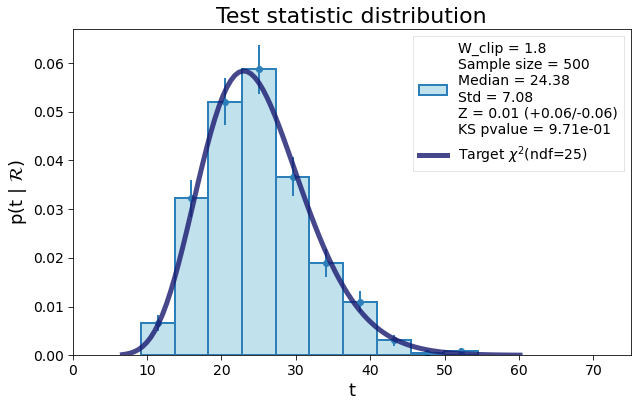

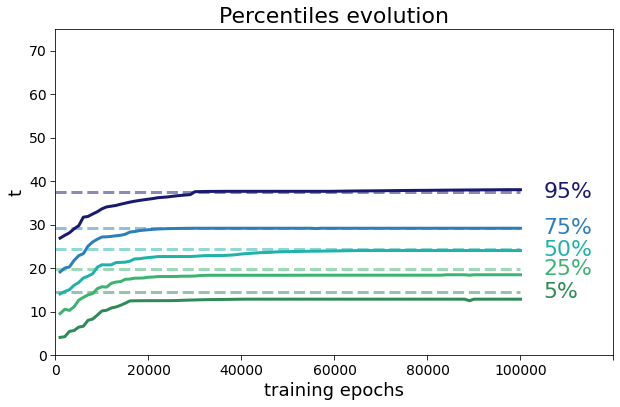

In [43]:
SAVE = False

save_path = f"./plots/{DATA_RUN}/"

file_name   = f"Nref{N_REF}_Ndata{N_DATA}_epochsTau{EPOCHS}"
file_name  += f"_arc{str(ARCHITECTURE).replace(', ', '_').replace('[', '').replace(']', '')}"
file_name  += f"_wclip{WEIGHT_CLIPPING}"

modules.analysis_utils.plot_1distribution(
    t=tau, 
    df=dof, 
    xmin=None, 
    xmax=None, 
    nbins=10, 
    wclip=WEIGHT_CLIPPING, 
    save=SAVE, 
    save_path=save_path, 
    file_name=file_name
)
modules.analysis_utils.plot_percentiles(
    tvalues_check=tau_history, 
    df=dof, 
    patience=1000, 
    ymin=0, 
    ymax=None, 
    wclip=WEIGHT_CLIPPING, 
    smooth=True, 
    save=SAVE,
    save_path=save_path, 
    file_name=file_name
)